In [2]:
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RealEstateAvgPriceAnalysis") \
    .getOrCreate()

In [3]:
dataset = spark.read.option("header", "true").option("inferSchema", "true").csv("dataset.csv")
dataset.show(5)

+-----------+-------------+------------------+---------------+---------------+--------------+---------------+----------------+-----------------+-----------+------------+--------------------+----------------+-------------------+------------------+--------------+------------------+-------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+---------------+----------+-------------------+-------------------------+-------------------+--------------+----------------------------+-----------------------+---------------+---------+---------+--------------+-------------------------------+------------------+-------------------+------------------+
|id_mutation|date_mutation|numero_disposition|nature_mutation|valeur_fonciere|adresse_numero|adresse_suffixe|adresse_nom_voie|adresse_code_voie|code_postal|code_commune|         nom_commune|code_departement|ancien_code_commune|anci

In [4]:
dataset.printSchema()

root
 |-- id_mutation: string (nullable = true)
 |-- date_mutation: date (nullable = true)
 |-- numero_disposition: integer (nullable = true)
 |-- nature_mutation: string (nullable = true)
 |-- valeur_fonciere: double (nullable = true)
 |-- adresse_numero: integer (nullable = true)
 |-- adresse_suffixe: string (nullable = true)
 |-- adresse_nom_voie: string (nullable = true)
 |-- adresse_code_voie: string (nullable = true)
 |-- code_postal: integer (nullable = true)
 |-- code_commune: string (nullable = true)
 |-- nom_commune: string (nullable = true)
 |-- code_departement: string (nullable = true)
 |-- ancien_code_commune: integer (nullable = true)
 |-- ancien_nom_commune: string (nullable = true)
 |-- id_parcelle: string (nullable = true)
 |-- ancien_id_parcelle: string (nullable = true)
 |-- numero_volume: string (nullable = true)
 |-- lot1_numero: string (nullable = true)
 |-- lot1_surface_carrez: double (nullable = true)
 |-- lot2_numero: string (nullable = true)
 |-- lot2_surface

In [5]:
# Filter the dataset to remove rows where prix_m2 is null
dataset = dataset.filter(dataset["prix_m2"].isNotNull())

In [6]:
from pyspark import Row
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Collecter les coordonnées et les valeurs foncières dans des listes
data_LL = dataset.select("id_mutation", "longitude_r", "latitude_r", "prix_m2").collect()
coordinates = np.array([(row['longitude_r'], row['latitude_r']) for row in data_LL])
prices = np.array([row['prix_m2'] for row in data_LL])

# Utiliser NearestNeighbors pour trouver les 10 plus proches voisins
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(coordinates)
distances, indices = nbrs.kneighbors(coordinates)

In [7]:
# Calculer la moyenne des prix et des distances des 10 plus proches voisins
average_prices = np.array([prices[neighbors].mean() for neighbors in indices])
average_distances = np.array([distances[i].mean() for i in range(len(distances))])

# Assurer que les valeurs sont de type float
average_prices = [float(price) for price in average_prices]
average_distances = [float(distance) for distance in average_distances]

# Convertir les données en Row pour créer un DataFrame PySpark
coordinates_prices = [Row(id_mutation=data_LL[i]['id_mutation'], average_neighbor_price=average_prices[i], 
                          average_neighbor_distance=average_distances[i]) for i in range(len(data_LL))]
df_avg_prices = spark.createDataFrame(coordinates_prices)

In [8]:
from pyspark.sql import functions as F

# Aggregate df_avg_prices by id_mutation
df_avg_prices_agg = df_avg_prices.groupBy("id_mutation").agg(
    F.avg("average_neighbor_price").alias("avg_neighbor_price"),
    F.avg("average_neighbor_distance").alias("avg_neighbor_dist")
)

In [9]:
# Joindre les moyennes au DataFrame initial
print("Before joining:" + str(dataset.count()) + ", " + str(df_avg_prices_agg.count()))
data = dataset.join(df_avg_prices_agg, "id_mutation", "left")
print("After joining:" + str(data.count()))

Before joining:206946, 182685
After joining:206946


In [10]:
data.show(5)

+-----------+-------------+------------------+---------------+---------------+--------------+---------------+--------------------+-----------------+-----------+------------+--------------------+----------------+-------------------+------------------+--------------+------------------+-------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+---------------+----------+-------------------+-------------------------+-------------------+--------------+----------------------------+-----------------------+---------------+---------+---------+--------------+-------------------------------+------------------+-------------------+------------------+------------------+--------------------+
|id_mutation|date_mutation|numero_disposition|nature_mutation|valeur_fonciere|adresse_numero|adresse_suffixe|    adresse_nom_voie|adresse_code_voie|code_postal|code_commune|         nom_c

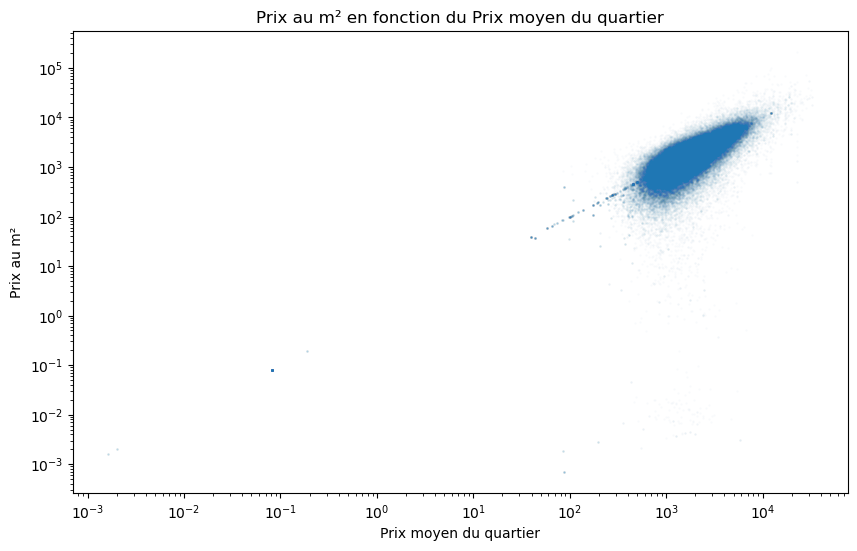

In [11]:
from matplotlib import pyplot as plt

# Convertir le DataFrame en Pandas DataFrame
filtered_data = data.toPandas()

# Tracer les données
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data["avg_neighbor_price"], filtered_data["prix_m2"], alpha=0.03, s=0.2)
plt.xlabel("Prix moyen du quartier")
plt.ylabel("Prix au m²")
plt.title("Prix au m² en fonction du Prix moyen du quartier")

# Ajuster les échelles des axes pour correspondre
# plt.xlim(0, filtered_data["avg_neighbor_price"].max())
# plt.ylim(0, filtered_data["prix_m2"].max())

# Ajuster l'échelle des axes en logarithmique
plt.xscale("log")
plt.yscale("log")

plt.show()

In [12]:
data.filter(data["prix_m2"] < 10).show(30)

+-----------+-------------+------------------+---------------+---------------+--------------+---------------+--------------------+-----------------+-----------+------------+-----------------+----------------+-------------------+------------------+--------------+------------------+-------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+---------------+-----------+-------------------+-------------------------+-------------------+--------------+----------------------------+-----------------------+---------------+---------+---------+--------------+-------------------------------+--------------------+--------------------+------------------+------------------+--------------------+
|id_mutation|date_mutation|numero_disposition|nature_mutation|valeur_fonciere|adresse_numero|adresse_suffixe|    adresse_nom_voie|adresse_code_voie|code_postal|code_commune|      nom_com

In [14]:
# Convert radians to degrees
filtered_data['longitude_deg'] = np.degrees(filtered_data['longitude_r'])
filtered_data['latitude_deg'] = np.degrees(filtered_data['latitude_r'])

import folium

# Initialize the map centered around the average coordinates
map_center = [filtered_data['latitude_deg'].mean(), filtered_data['longitude_deg'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Normalize price_per_m2 for color mapping
min_price = filtered_data['prix_m2'].min()
max_price = filtered_data['prix_m2'].max()

def get_color(price):
    norm_price = (price - min_price) / (max_price - min_price)
    # Return a color gradient from blue to red
    return f"#{int(255 * norm_price):02x}00{int(255 * (1 - norm_price)):02x}"

# Add points to the map
for idx, row in filtered_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude_deg'], row['longitude_deg']],
        radius=5,
        color=get_color(row['prix_m2']),
        fill=True,
        fill_color=get_color(row['prix_m2']),
        fill_opacity=0.7,
        popup=f"Price: {row['prix_m2']} €/m²"
    ).add_to(m)

# Save the map to an HTML file
m.save('map.html')

KeyboardInterrupt: 

In [15]:
data.write.option("header", "true").option("inferSchema", "true").csv("dataset_with_neighbor.csv")

In [16]:
spark.stop()